In [17]:
%matplotlib inline
#  disable transparency for gif making
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import os
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from shapely.geometry import Point

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import contextily as cx

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
svi_dir = os.path.join(data_dir,'SocialVulnerabilityIndex')
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [3]:
svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)

In [4]:
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf

just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [5]:
deaths_gdf = deaths_gdf.fillna(deaths_gdf.mean())
deaths_gdf = deaths_gdf.drop_duplicates(['grid_squar','year','quarter','deaths'])

In [6]:
# Make lat and lon floats
deaths_gdf.loc[:, 'lat'] = deaths_gdf.lat.astype(float)
deaths_gdf.loc[:, 'lon'] = deaths_gdf.lon.astype(float)

In [7]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [8]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [9]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)
deaths_gdf.loc[idx[:,:,:],'delta_deaths'] = deaths_gdf.loc[idx[:,:,:],'deaths'] - deaths_gdf.loc[idx[:,:,:],'self_t-1']
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [10]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [11]:
ref_locations = [
    ('N. Cambridge', 3549.01),
    ('Arlington', 3564),
    ('Springfield', 8019.02),
    ('Pittsfield', 9001),
    ('Brockton', 5107),
    ('Lawrence', 2501.00),
    ('Nantucket', 9504.00),
    ('Falmouth', 146.00),
]

In [13]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [14]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','timestep','delta_deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','timestep','delta_deaths']]


In [15]:
comparators = [
('N. Cambridge', 42.3934,  -71.1309),
 ('Jamaica Plain', 42.3132,  -71.1141),
 ('Springfield', 42.1015, -72.5898),
 ('Pittsfield', 42.4501, -73.2454),
 ('Brockton', 42.0834, -71.0184),
 ('Lawrence', 42.7070, -71.1631),
 ('Nantucket', 41.2835, -70.0995),
 ('Falmouth', 41.5532, -70.6086)]

In [20]:
just_one_year = svi_gdf.loc[svi_gdf['year']==2000, ['grid_squar','geometry','lat','lon']]

In [22]:
matching_squares = []
for city, lat, lon in comparators:
    point = Point(lon, lat)
    contains = just_one_year.contains(point)
    matching_square = just_one_year.loc[contains, 'grid_squar'].values[0]
    matching_centroid_lat = just_one_year.loc[contains, 'lat'].values[0]
    matching_centroid_lon = just_one_year.loc[contains, 'lon'].values[0]
    
    just_one_year.loc[:,'haversine'] = just_one_year.apply(lambda row: haversine(matching_centroid_lon, matching_centroid_lat,
                                                                         row['lon'], row['lat']),
                                                  axis=1)
    matching_neighbors = just_one_year[just_one_year['haversine']<5]['grid_squar'].values
    
    matching_squares.append((city, lat, lon, matching_square, matching_neighbors))

In [25]:
comparisons = pd.DataFrame(matching_squares, 
             columns=['name','lat','lon','center','neighbors'])

Text(0.5, 1.05, 'Data for comparison locations, 2001-2019')

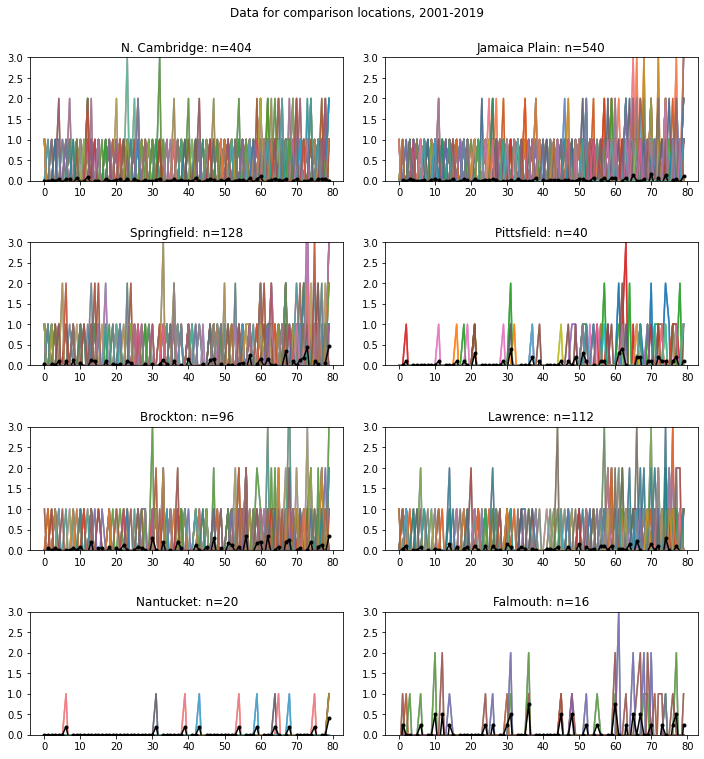

In [47]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
for c, comparison in comparisons.iterrows():
    row = int(np.floor(c/2))
    col = c%2
    ax = axs[row, col]
    
    neighbors = [neighbor for neighbor in comparison['neighbors']]
    
    for neighbor in neighbors:
        this_city = train_y_through_2019[train_y_through_2019['grid_squar']==neighbor]

        ax.plot(np.arange(0,80), this_city['delta_deaths'], alpha=0.5)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylim([0,3])
        ax.set_title(f"{comparison['name']}: n={len(neighbors)}")
        
    avg =  train_y_through_2019[train_y_through_2019['grid_squar'].isin(neighbors)].groupby('timestep').mean()['delta_deaths']
    ax.plot(np.arange(0, 80), avg, 'k.-')
fig.suptitle("Data for comparison locations, 2001-2019",y=1.05)

In [41]:
train_y_through_2019

,grid_squar,timestep,delta_deaths
0,25001010100,0.0,0.0
1,25001010100,1.0,0.0
2,25001010100,2.0,0.0
3,25001010100,3.0,0.0
4,25001010100,4.0,3.0
...,...,...,...
142547,25027761402,75.0,-1.0
142548,25027761402,76.0,0.0
142549,25027761402,77.0,0.0
142550,25027761402,78.0,0.0
